## Prueba de selección: Línea de Salud Digital, Centro de Modelamiento Matemático, Universidad de Chile, Septiembre 2023

### Descripción del problema:
Predicción del máximo anual de casos activos de COVID-19.
La pandemia del COVID-19 fue un evento de interes de salud pública sin precedentes, especialmente
debido a la gran disponibilidad de datos públicos para su análisis.
El repositorio de series de tiempo de casos totales de COVID-19 está disponible en https://github.com/
MinCiencia/Datos-COVID19/tree/master/output/producto5 y se le solicita modelar este fenómeno utilizando aprendizaje automático.

**a) Importe la tabla que usted considere más útil desde el repositorio y muestre un análisis exploratorio
del conjunto de datos, enfocándose en su estacionalidad y tendencia.**

In [2]:
# Se importa librerias
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Se importa datframe desde su direccion url 
url = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto5/TotalesNacionales_T.csv'
covid = pd.read_csv(url)
# seleccion variable casos activos
covid_new = covid[['Casos activos','Fecha']]
covid_new = pd.DataFrame(covid_new)

# Cambiar el tipo de dato de la columna a fecha
covid_new['Fecha'] = pd.to_datetime(covid_new['Fecha'], format='%Y-%m-%d')


In [3]:
# Configurar 'Fecha' como el índice del DataFrame
covid_new.set_index('Fecha', inplace=True)
# ordenar fechas ('D')
covid_new = covid_new.sort_index()
# incluir frecuencia del índice ('D')
covid_new = covid_new.asfreq('D')

In [4]:
# Backfill: Llena los valores faltantes con el valor anterior
covid_new.fillna(method='bfill', inplace=True)

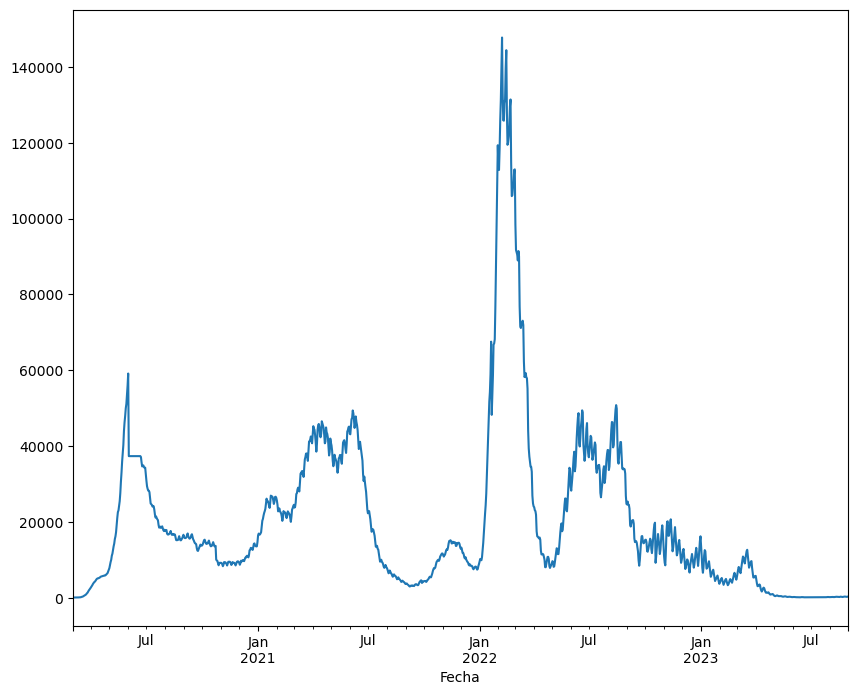

In [5]:
# graficando
plot = covid_new['Casos activos'].plot(figsize=(10, 8))

In [6]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico,capturando la tendencia a largo plazo.
lambda_anual = 16000000
covid_new_ciclo,covid_new_tend = sm.tsa.filters.hpfilter(covid_new['Casos activos'],lamb=lambda_anual)
covid_new['tendencia'] = covid_new_tend


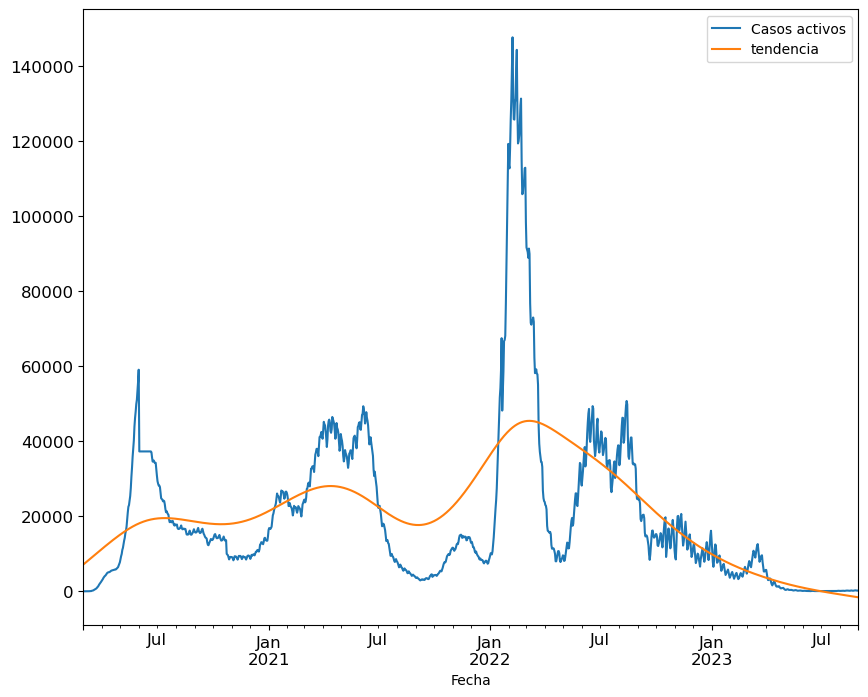

In [7]:
# graficando casos activos con su tendencia.
covid_new[['Casos activos', 'tendencia']].plot(figsize=(10, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);


### Comentario de tendencia:
A lo largo del tiempo, se ha evidenciado un incremento sostenido en la cantidad de casos activos desde el inicio del registro hasta el punto más alto alcanzado el 22 de marzo. Posteriormente, se aprecia un cambio en esta tendencia, con una disminución constante que llega hasta la fecha de septiembre 23.
En cuanto a la perspectiva a corto plazo, se han identificado cambios significativos en las tendencias antes de llegar al pico registrado en marzo, particularmente durante los meses de mayo y julio.


In [8]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico,capturando comportamiento ciclo a corto plazo.
covid_new_ciclo, covid_new_tend = sm.tsa.filters.hpfilter(covid_new['Casos activos'])
covid_new['ciclo'] = covid_new_ciclo

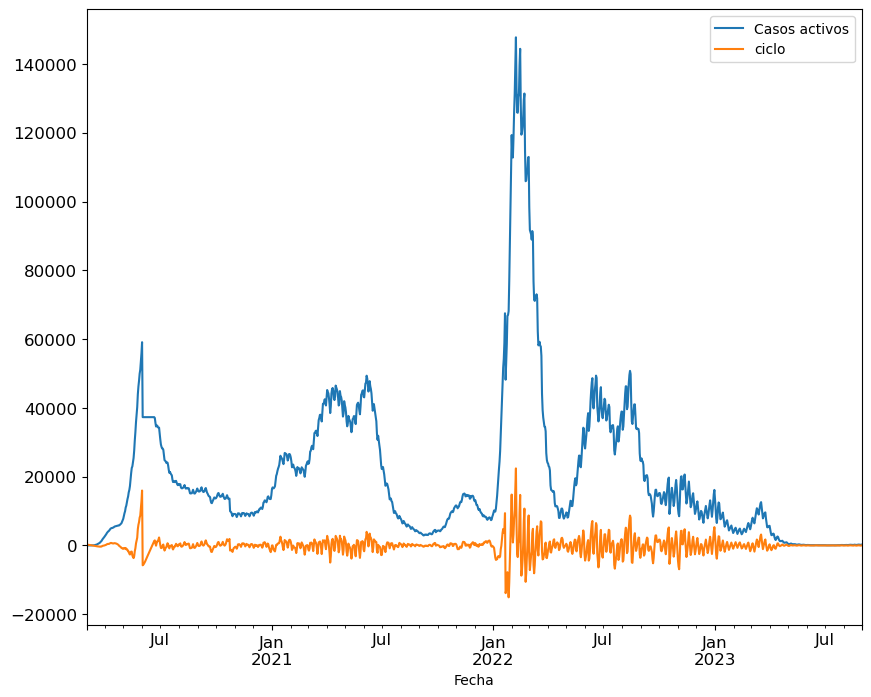

In [9]:
# graficando la variacion del precio real con los ciclos a corto plazo.
covid_new[['Casos activos', 'ciclo']].plot(figsize=(10, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);

### Comentario estacionalidad:

Se han identificado picos en los meses de invierno, donde se alcanza el máximo de contagios de casos activos. Es importante destacar que el pico atípico registrado en marzo del año 2022 se debió al termino de cuarentenas mas estrictas, lo que lo convierte en un punto excepcional en el contexto general.
Los valles más significativos se observan después del mes de julio, seguidos de un aumento al comienzo de cada año.
El plan de vacunación implementado durante el último trimestre de 2022 marcó un cambio significativo en la tendencia de los casos activos, rompiendo el patrón observado en años anteriores al provocar una disminución notable en la cantidad de casos a la fecha.


**b) Utilice los datos disponibles en el repositorio para diseñar una estrategia para la prediccion del
maximo anual de casos activos para cada año de la alerta sanitaria. Describa detalladamente su
estrategia de ajuste del modelo y su validacion.**

In [20]:
# librerias a utilizar
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

In [28]:
# quito las variables de ejercicio anterior
covid_new = covid_new[['Casos activos']]

# conjuntos de entrenamiento y prueba
porcentaje_entrenamiento = 0.8
n_entrenamiento = int(len(covid_new) * porcentaje_entrenamiento)
conjunto_entrenamiento = covid_new.iloc[:n_entrenamiento]
conjunto_prueba = covid_new.iloc[n_entrenamiento:]

In [29]:
def preparar_datos(covid_new, time_steps):
    X, y = [], []
    for i in range(len(covid_new) - time_steps):
        X.append(covid_new.iloc[i:i+time_steps].values)
        y.append(covid_new.iloc[i+time_steps].values)
    return np.array(X), np.array(y)

time_steps = 10  # Número de pasos temporales anteriores para usar en la predicción
X_train, y_train = preparar_datos(conjunto_entrenamiento, time_steps)
X_test, y_test = preparar_datos(conjunto_prueba, time_steps)

In [30]:
# Crear y compilar el modelo RNN
model = Sequential([
    SimpleRNN(units=50, activation='relu', input_shape=(time_steps, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [31]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=16)


Epoch 1/50
64/64 [==============================] - 1s 3ms/step - loss: 309201920.0000
Epoch 2/50
64/64 [==============================] - 0s 3ms/step - loss: 9162472.0000
Epoch 3/50
64/64 [==============================] - 0s 3ms/step - loss: 9017191.0000
Epoch 4/50
64/64 [==============================] - 0s 3ms/step - loss: 10179855.0000
Epoch 5/50
64/64 [==============================] - 0s 3ms/step - loss: 7883827.0000
Epoch 6/50
64/64 [==============================] - 0s 3ms/step - loss: 6276267.5000
Epoch 7/50
64/64 [==============================] - 0s 3ms/step - loss: 5929815.5000
Epoch 8/50
64/64 [==============================] - 0s 3ms/step - loss: 4951414.5000
Epoch 9/50
64/64 [==============================] - 0s 3ms/step - loss: 5361070.5000
Epoch 10/50
64/64 [==============================] - 0s 3ms/step - loss: 4440758.0000
Epoch 11/50
64/64 [==============================] - 0s 3ms/step - loss: 5371088.5000
Epoch 12/50
64/64 [==============================] - 0s 3ms/

In [32]:
# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test, y_test)
print(f"Pérdida en el conjunto de prueba: {loss}")

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

8/8 [==============================] - 0s 2ms/step - loss: 131293.0156
Pérdida en el conjunto de prueba: 131293.015625
8/8 [==============================] - 0s 3ms/step


In [35]:
# Crear un DataFrame con las fechas de las predicciones
fechas_prediccion = conjunto_prueba.index[time_steps:]
df_predicciones = pd.DataFrame({'Fecha': fechas_prediccion, 'Prediccion': predictions.flatten()})
# indexar
df_predicciones.set_index('Fecha', inplace=True)


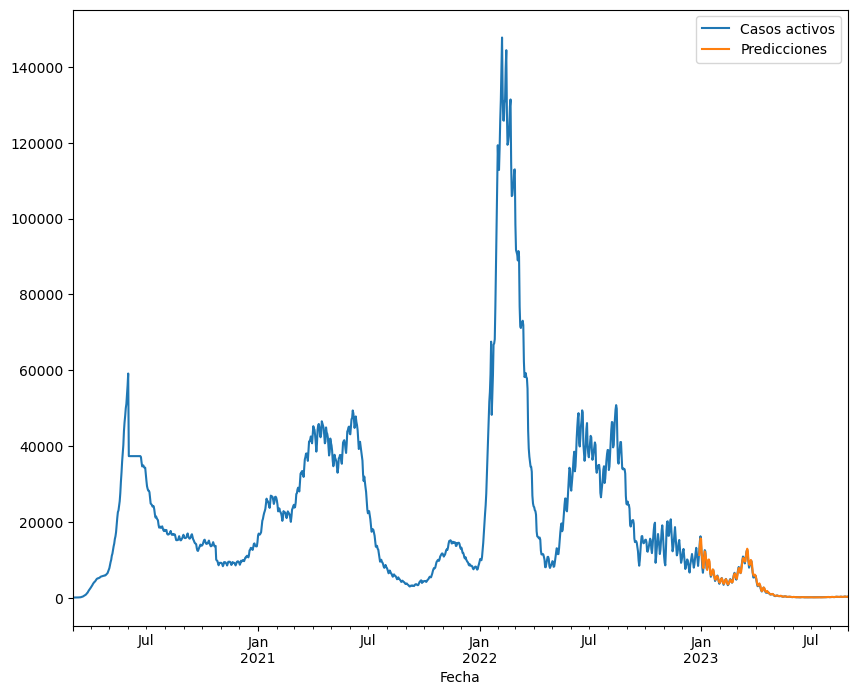

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
covid_new['Casos activos'].plot(ax=ax, label='Casos activos')
df_predicciones['Prediccion'].plot(ax=ax, label='Predicciones')
ax.legend();

In [49]:
max(predictions)

array([15605.36], dtype=float32)

### Comentarios sobre resultados del modelo

La elección de un modelo de Red Neuronal Recurrente (RNN) para pronosticar el comportamiento de casos activos de COVID-19 se justifica por su capacidad para capturar dependencias temporales en datos secuenciales y adaptarse a cambios en los patrones de la pandemia. Las RNN son ideales para modelar la dinámica compleja de la propagación del virus y pueden mejorar su rendimiento a medida que se recopilan más datos.
Las estimaciones del modelo ajustado muestran un seguimiento preciso con los datos reales de casos activos de COVID-19 durante el último año, reflejando de manera efectiva las tendencias y picos. Esto sugiere que el modelo es capaz de capturar patrones subyacentes en los datos y puede ser una herramienta para pronósticos y toma de decisiones en la gestión de la pandemia.
El máximo de casos activos estimados por el modelo en el último año hasta la fecha es de 15,605 casos. Este valor representa el pico de casos activos según la estimación durante ese período específico, es importante seguir monitoreando y validando estas estimaciones a medida que se obtienen más datos.
